In [1]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
import os
caffe_root = '/Users/mason/caffe/'
os.chdir(caffe_root)
print 'current dir is: {}'.format(os.getcwd())
import sys
sys.path.append(caffe_root + 'python')
import caffe

from google.protobuf import text_format
from caffe.proto import caffe_pb2

current dir is: /Users/mason/caffe


In [2]:
#chech the ssd model file
path='/Users/mason/Desktop/map_recongnition_deploy/deploy_yuuav/'
#model_path=path+'VGG_VOC0712_SSD_300x300_iter_120000.caffemodel'
model_path=path+'VGG_YUUAV_SSD_300x300_iter_50000.caffemodel'
if os.path.isfile(model_path):
    print 'caffe_ssd model found.' 
else:
    print 'Please downloading the caffe_ssd model'

#maping label_2_name
#label_file=path+'labelmap_voc.prototxt'
label_file=path+'labelmap_yuuav.prototxt'
file = open(label_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)


def label_2_name(labelmap, labels):
    num_labels=len(labelmap.item)
    labelnames=[]
    if type(labels) is not list:
        labels=labels.tolist()
    for label in labels:
        found= False
        for i in range(0, num_labels):
            if label==labelmap.item[i].label:
                found =True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found==True # raise is not         
    return labelnames

#load the deploy net 
caffe.set_mode_cpu()

deploy_net=path+'deploy.prototxt'
model_weights=model_path

print 'deploy_net: {}; \nmodel_weights: {}; \nlabel_file:{};'.format(deploy_net,model_weights,label_file)

caffe_ssd model found.
deploy_net: /Users/mason/Desktop/map_recongnition_deploy/deploy_yuuav/deploy.prototxt; 
model_weights: /Users/mason/Desktop/map_recongnition_deploy/deploy_yuuav/VGG_YUUAV_SSD_300x300_iter_50000.caffemodel; 
label_file:/Users/mason/Desktop/map_recongnition_deploy/deploy_yuuav/labelmap_yuuav.prototxt;


In [3]:
net= caffe.Net(deploy_net,model_weights,caffe.TEST)

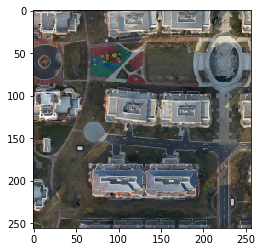

In [6]:
#set up input preprocessing 
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) #set up data trasformer layer

mean_value=[104,117,123] 
transformer.set_transpose('data',(2,0,1)) #move image channels to outermost dimension
transformer.set_mean('data', np.array(mean_value))
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0))# RGB to BGR 

#laod image
#image_path=path+'test_image/test.jpg'
image_path=path+'test_image/test3.png'
image=caffe.io.load_image(image_path)
plt.imshow(image)

net.blobs['data'].reshape(1,
                          3,300,300)
transformed_image=transformer.preprocess('data',image )
net.blobs['data'].data[...]=transformed_image

[2. 2. 2. 2.] [u'building', u'building', u'building', u'building']
building: 0.866525948048
building: 0.777570128441
building: 0.616997480392
building: 0.609117805958


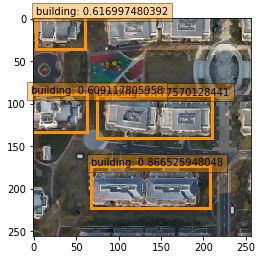

In [7]:
#SSD Detection
############################

#Forward pass and then output the detection(box and label)
detection =net.forward()['detection_out']
#print detection
#output with all conf
det_label=detection[0,0,:,1]
det_conf=detection[0,0,:,2]
assert np.array(det_conf).shape[0] >=1
det_xmin =detection[0,0,:,3] # xmin or other is not mean the reall pixel distance, is a scale
det_ymin=detection[0,0,:,4]
det_xmax=detection[0,0,:,5]
det_ymax=detection[0,0,:,6]


#output with filter :get output with confidence higher than 0.6
top_indicates=[i for i, conf in enumerate(det_conf) if conf >=0.6] # i is the index， so top_indicates is a index list 
top_conf=det_conf[top_indicates]
top_label_indicates=det_label[top_indicates]
top_label=label_2_name(labelmap,top_label_indicates) #top_label_indicates is a list
print top_label_indicates, top_label
top_xmin=det_xmin[top_indicates]
top_ymin=det_ymin[top_indicates]
top_xmax=det_xmax[top_indicates]
top_ymax=det_ymax[top_indicates]

#####################################


#plot image and overload the boxes wiht label 
colors=plt.cm.hsv(np.linspace(0,1,21)).tolist()
plt.imshow(image)

currentAxis=plt.gca()# set up the Axis gca means:get current axis

for i in xrange(top_conf.shape[0]):
    xmin= int (round(top_xmin[i]*image.shape[1]))# multiple image.shape[1], because the top_xmin is a scale/rate 
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))

    score=top_conf[i]
    label=int(top_label_indicates[i])
    label_name=top_label[i]
    
    display_txt='{}: {}'.format(label_name, score)
    print display_txt
    coords=(xmin,ymin), xmax-xmin+1, ymax-ymin+1
    color =colors[label]

#draw the box
    currentAxis.add_patch(plt.Rectangle(*coords,fill=False, edgecolor=color, linewidth=3))#coords:[left_down point()，length，width]
    currentAxis.text(xmin,ymin, display_txt, bbox={'facecolor':color, 'alpha':0.4}) #alpha =  transparency
    